In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
from pathlib import Path
from collections import Counter
import csv
import seaborn as sns
import scipy
from slurm.gcd4da.commons.semi_kmeans import KMeans as SemiKMeans

In [5]:
with open('data/babel_v1.0_release/train.json', 'r') as f:
    x = json.load(f)

In [6]:
fps = 30
thres_sec = 1.
proc_labels = []
lengths = []
for i, (seq_id, seq) in enumerate(x.items()):
    frame_ann = seq['frame_ann']
    if frame_ann is None:
        label_dicts:list = seq['seq_ann']['labels']
        label_dicts:list = label_dicts if len(label_dicts) == 1 else []
    else:
        label_dicts = []
        for label_dict in frame_ann['labels']:
            length = label_dict['end_t'] - label_dict['start_t']
            lengths.append(length)
            if length >= thres_sec:
                label_dicts.append(label_dict)
    labels = [label_dict['proc_label'] for label_dict in label_dicts if label_dict['proc_label'] != 'transition']
    proc_labels += labels
lengths = np.array(lengths)
len(proc_labels), len(set(proc_labels))

(20008, 4611)

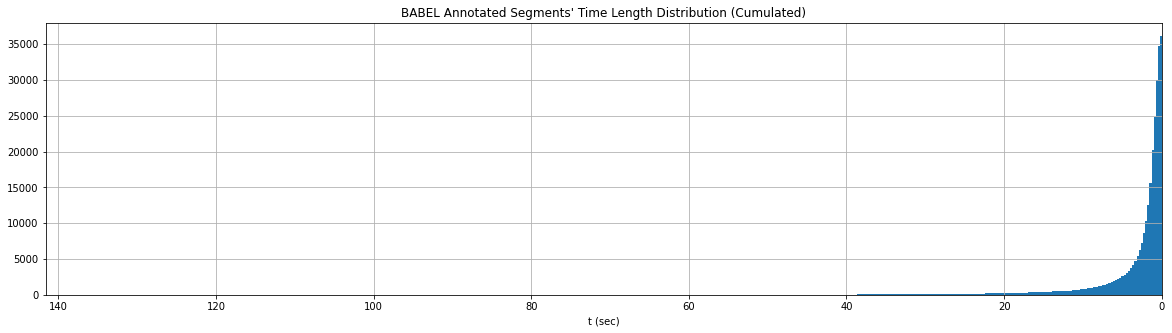

In [7]:
plt.figure(figsize=(20, 5))
plt.hist(lengths, bins=500, cumulative=-1)
plt.gca().invert_xaxis()
plt.xlabel('t (sec)')
plt.title('BABEL Annotated Segments\' Time Length Distribution (Cumulated)')
plt.grid()
plt.xlim(right=0)
plt.show()

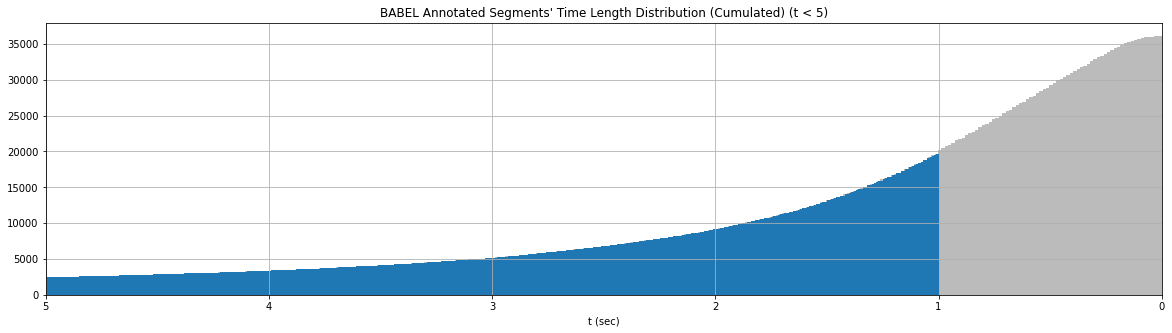

In [8]:
thres = 5
plt.figure(figsize=(20, 5))
plt.hist(lengths[lengths < thres].tolist() + [thres]*(lengths > thres).sum(), bins=500, cumulative=-1, color='#BBBBBB')
plt.hist(lengths[(lengths > 1) & (lengths < 5)].tolist() + [thres]*(lengths > thres).sum(), bins=400, cumulative=-1)
plt.gca().invert_xaxis()
plt.xlabel('t (sec)')
plt.title(f'BABEL Annotated Segments\' Time Length Distribution (Cumulated) (t < {thres})')
plt.grid()
plt.xlim(left=5, right=0)
plt.show()

In [ ]:
acc = 0
freq_thres = 1
babel_labels = []
with open('data/babel_labelset.csv', 'w') as f:
    writer = csv.writer(f)
    for k, freq in Counter(proc_labels).most_common():
        if k == 'transition':
            continue
        if freq < freq_thres:
            break
        babel_labels.append(k)
        acc += freq if freq >= freq_thres and k != 'transition' else 0
        print(f'{freq:5d} {k}')
        writer.writerow([k, freq])
babel_labelset = set(babel_labels)
print(len(babel_labelset))
print(acc)

In [ ]:
with open('/data/dataset/kinetics400/annotation/train.csv', 'r') as f:
    data = list(csv.reader(f))[1:]  # passing the header
k400_labels = [line[0] for line in data]
k400_labelset = set(k400_labels)
k400_labelset

In [1]:
import clip
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

def get_sim(labelset_x:list, labelset_y:list):
    x_features = get_feat(labelset_x)
    y_features = get_feat(labelset_y)
    sim = 100.0 * x_features @ y_features.T
    return sim.cpu().numpy()

def get_feat(strings:list, model=model, device=device):
    inputs = clip.tokenize(strings).to(device)
    with torch.no_grad():
        features = model.encode_text(inputs)
        features /= features.norm(dim=-1, keepdim=True)
    return features

In [2]:
feats = get_feat(['walk', 'walk forward'])

In [10]:
with Path('data/proc_label_clustered.json').open() as f:
    babel_label_clustered = json.load(f)
babel_parent_labels = list(babel_label_clustered)
babel_all_chilren_labels = sum(babel_label_clustered.values(), [])
child_to_parent_idx:dict = dict(
    sum(
        [
            [(child, babel_parent_labels.index(parent)) for child in children]
            for parent, children in babel_label_clustered.items()], []
    )
)

In [29]:
babel_features = get_feat(list(babel_labelset)).cpu().numpy()
known_data = [[] for _ in range(len(babel_label_clustered))]
for i, babel_label in enumerate(babel_labels):
    if babel_label not in babel_all_chilren_labels: continue
    known_data[child_to_parent_idx[babel_label]].append(i)
model = SemiKMeans(
    k=20, known_data=known_data, alpha=.3, verbose=False,
    metric='cosine', tol=1e-7, seed=1234
).fit(babel_features)

In [55]:
preds = model.predict(babel_features)

In [56]:
clusters = [[] for _ in range(20)]
for babel_label, pred in zip(babel_labels, preds):
    clusters[pred].append(babel_label)

In [ ]:
for k, cluster in enumerate(clusters):
    if k < len(babel_label_clustered):
        print(babel_parent_labels[k])
    print(k, cluster)
    print()

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2).fit_transform(babel_features)

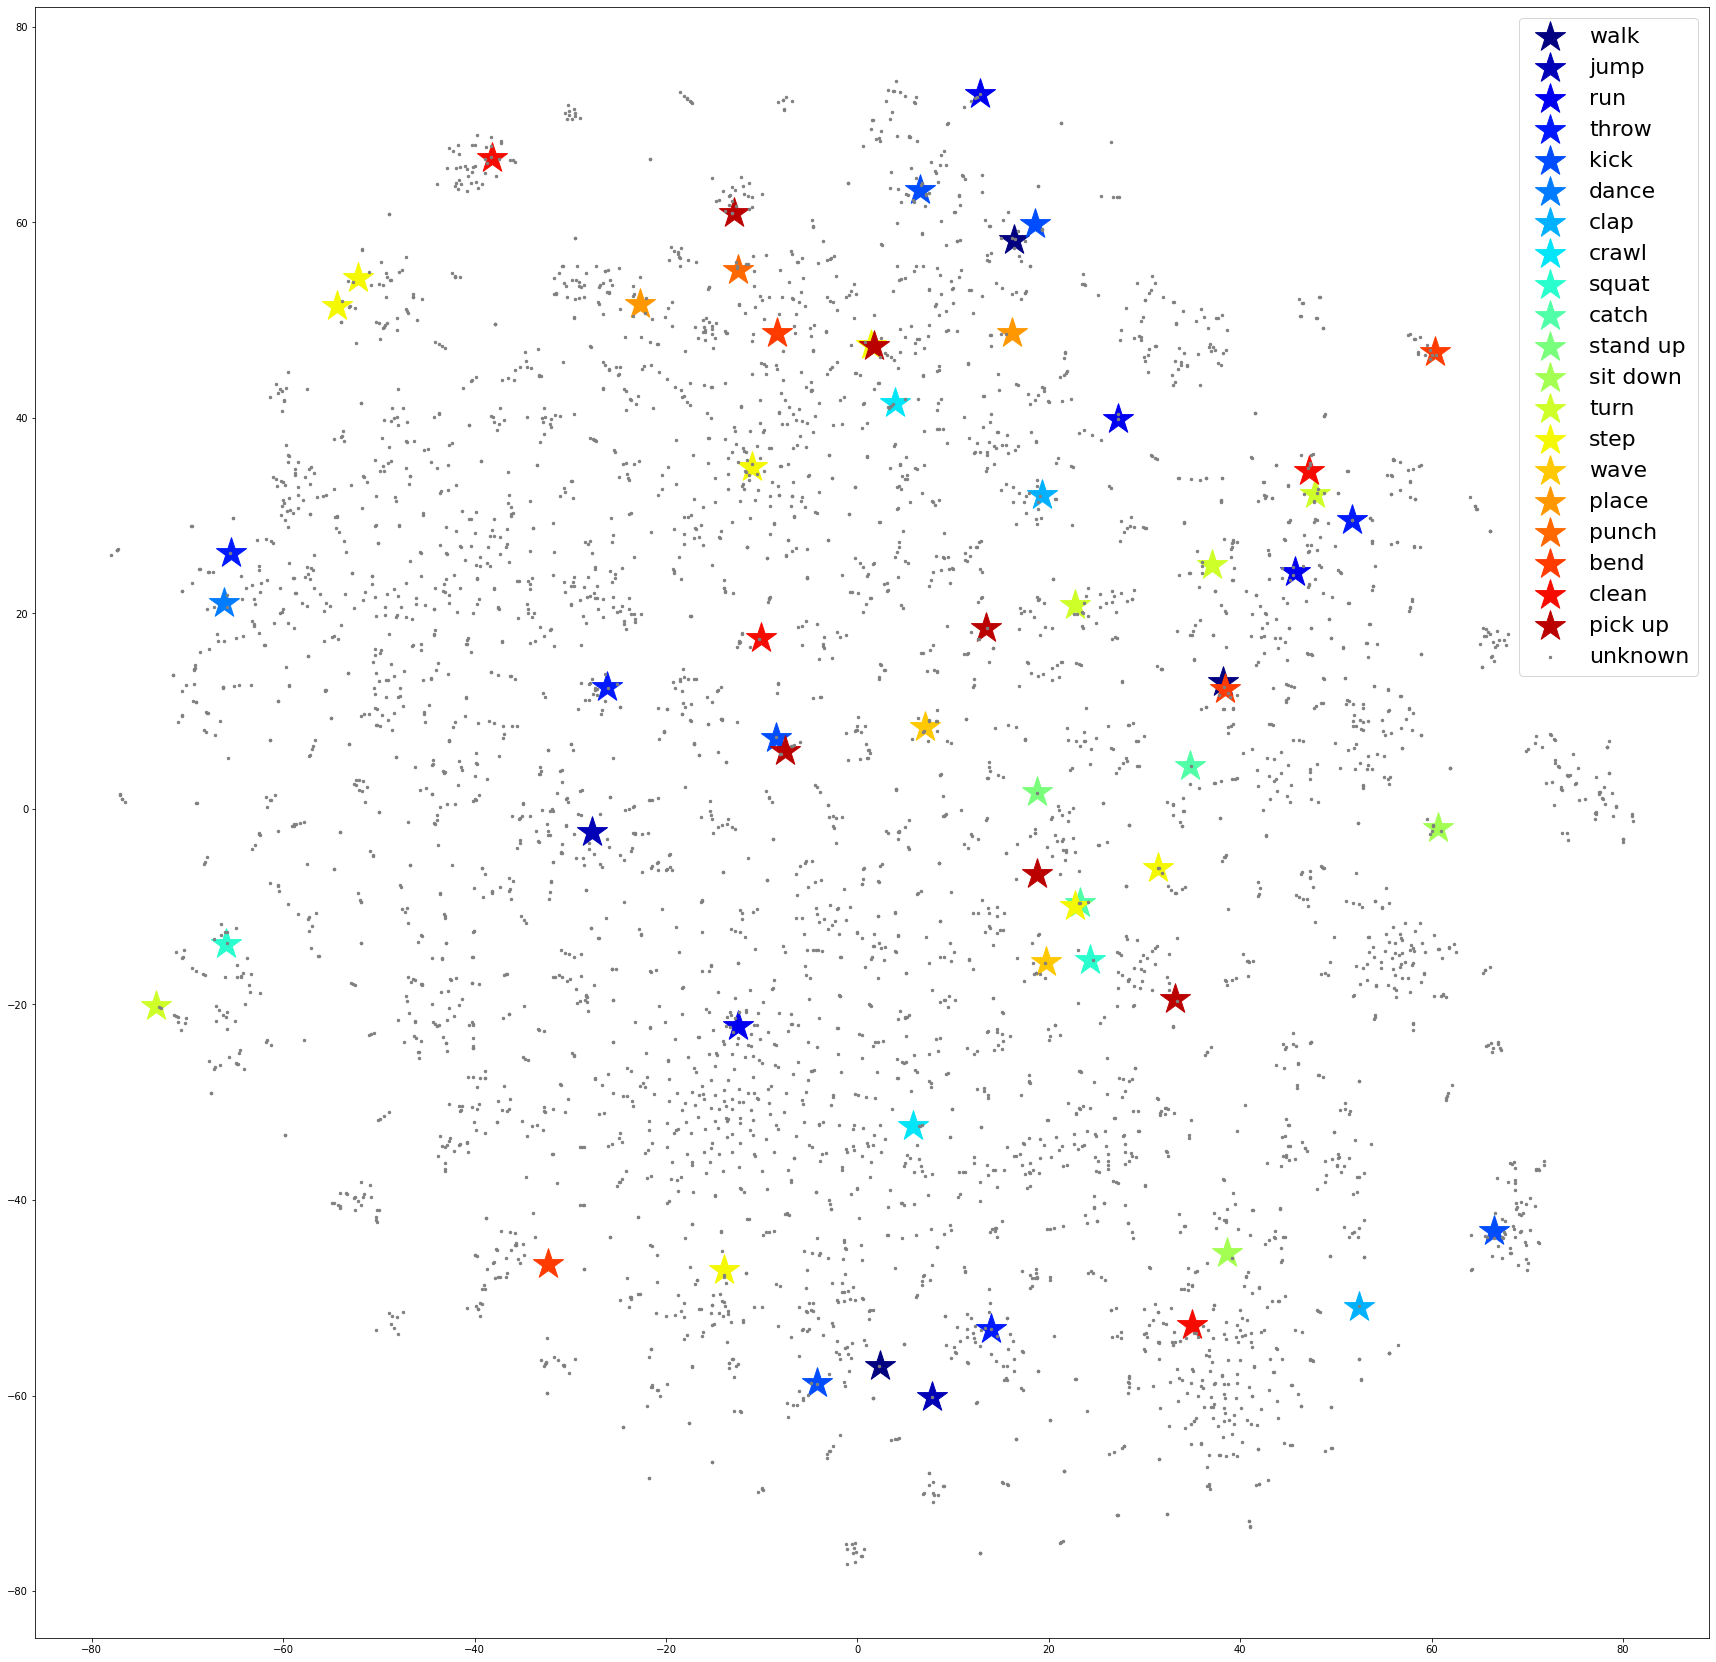

In [52]:
plt.figure(figsize=(30, 30))
jet = plt.get_cmap('jet')
for i, (known_data_c, parent_label) in enumerate(zip(known_data, babel_parent_labels)):
    plt.scatter(
        tsne[known_data_c,0], tsne[known_data_c,1],
        s=1000, marker='*', label=parent_label, color=jet(i*255//len(babel_label_clustered)))
unknown_data = list(set(range(len(babel_labels))) - set(sum(known_data, [])))
plt.scatter(tsne[unknown_data,0], tsne[unknown_data,1], s=6, color='gray', label='unknown')
plt.legend(fontsize=22)
plt.show() 

In [ ]:
import scipy.special
import pandas as pd
sim = (100. * k400_features @ k400_features.T).numpy()
sim -= np.diag(sim.diagonal())
sim = scipy.special.softmax(sim, axis=-1)
sim_trunced = sim.copy()
sim_trunced[sim < .5] = 0
df_trunced = pd.DataFrame(sim_trunced, columns=list(k400_labelset), index=list(k400_labelset))
df = pd.DataFrame(sim, columns=list(k400_labelset), index=list(k400_labelset))

In [ ]:
df.to_csv('k400.csv')
df_trunced.to_csv('k400_trunced.csv')

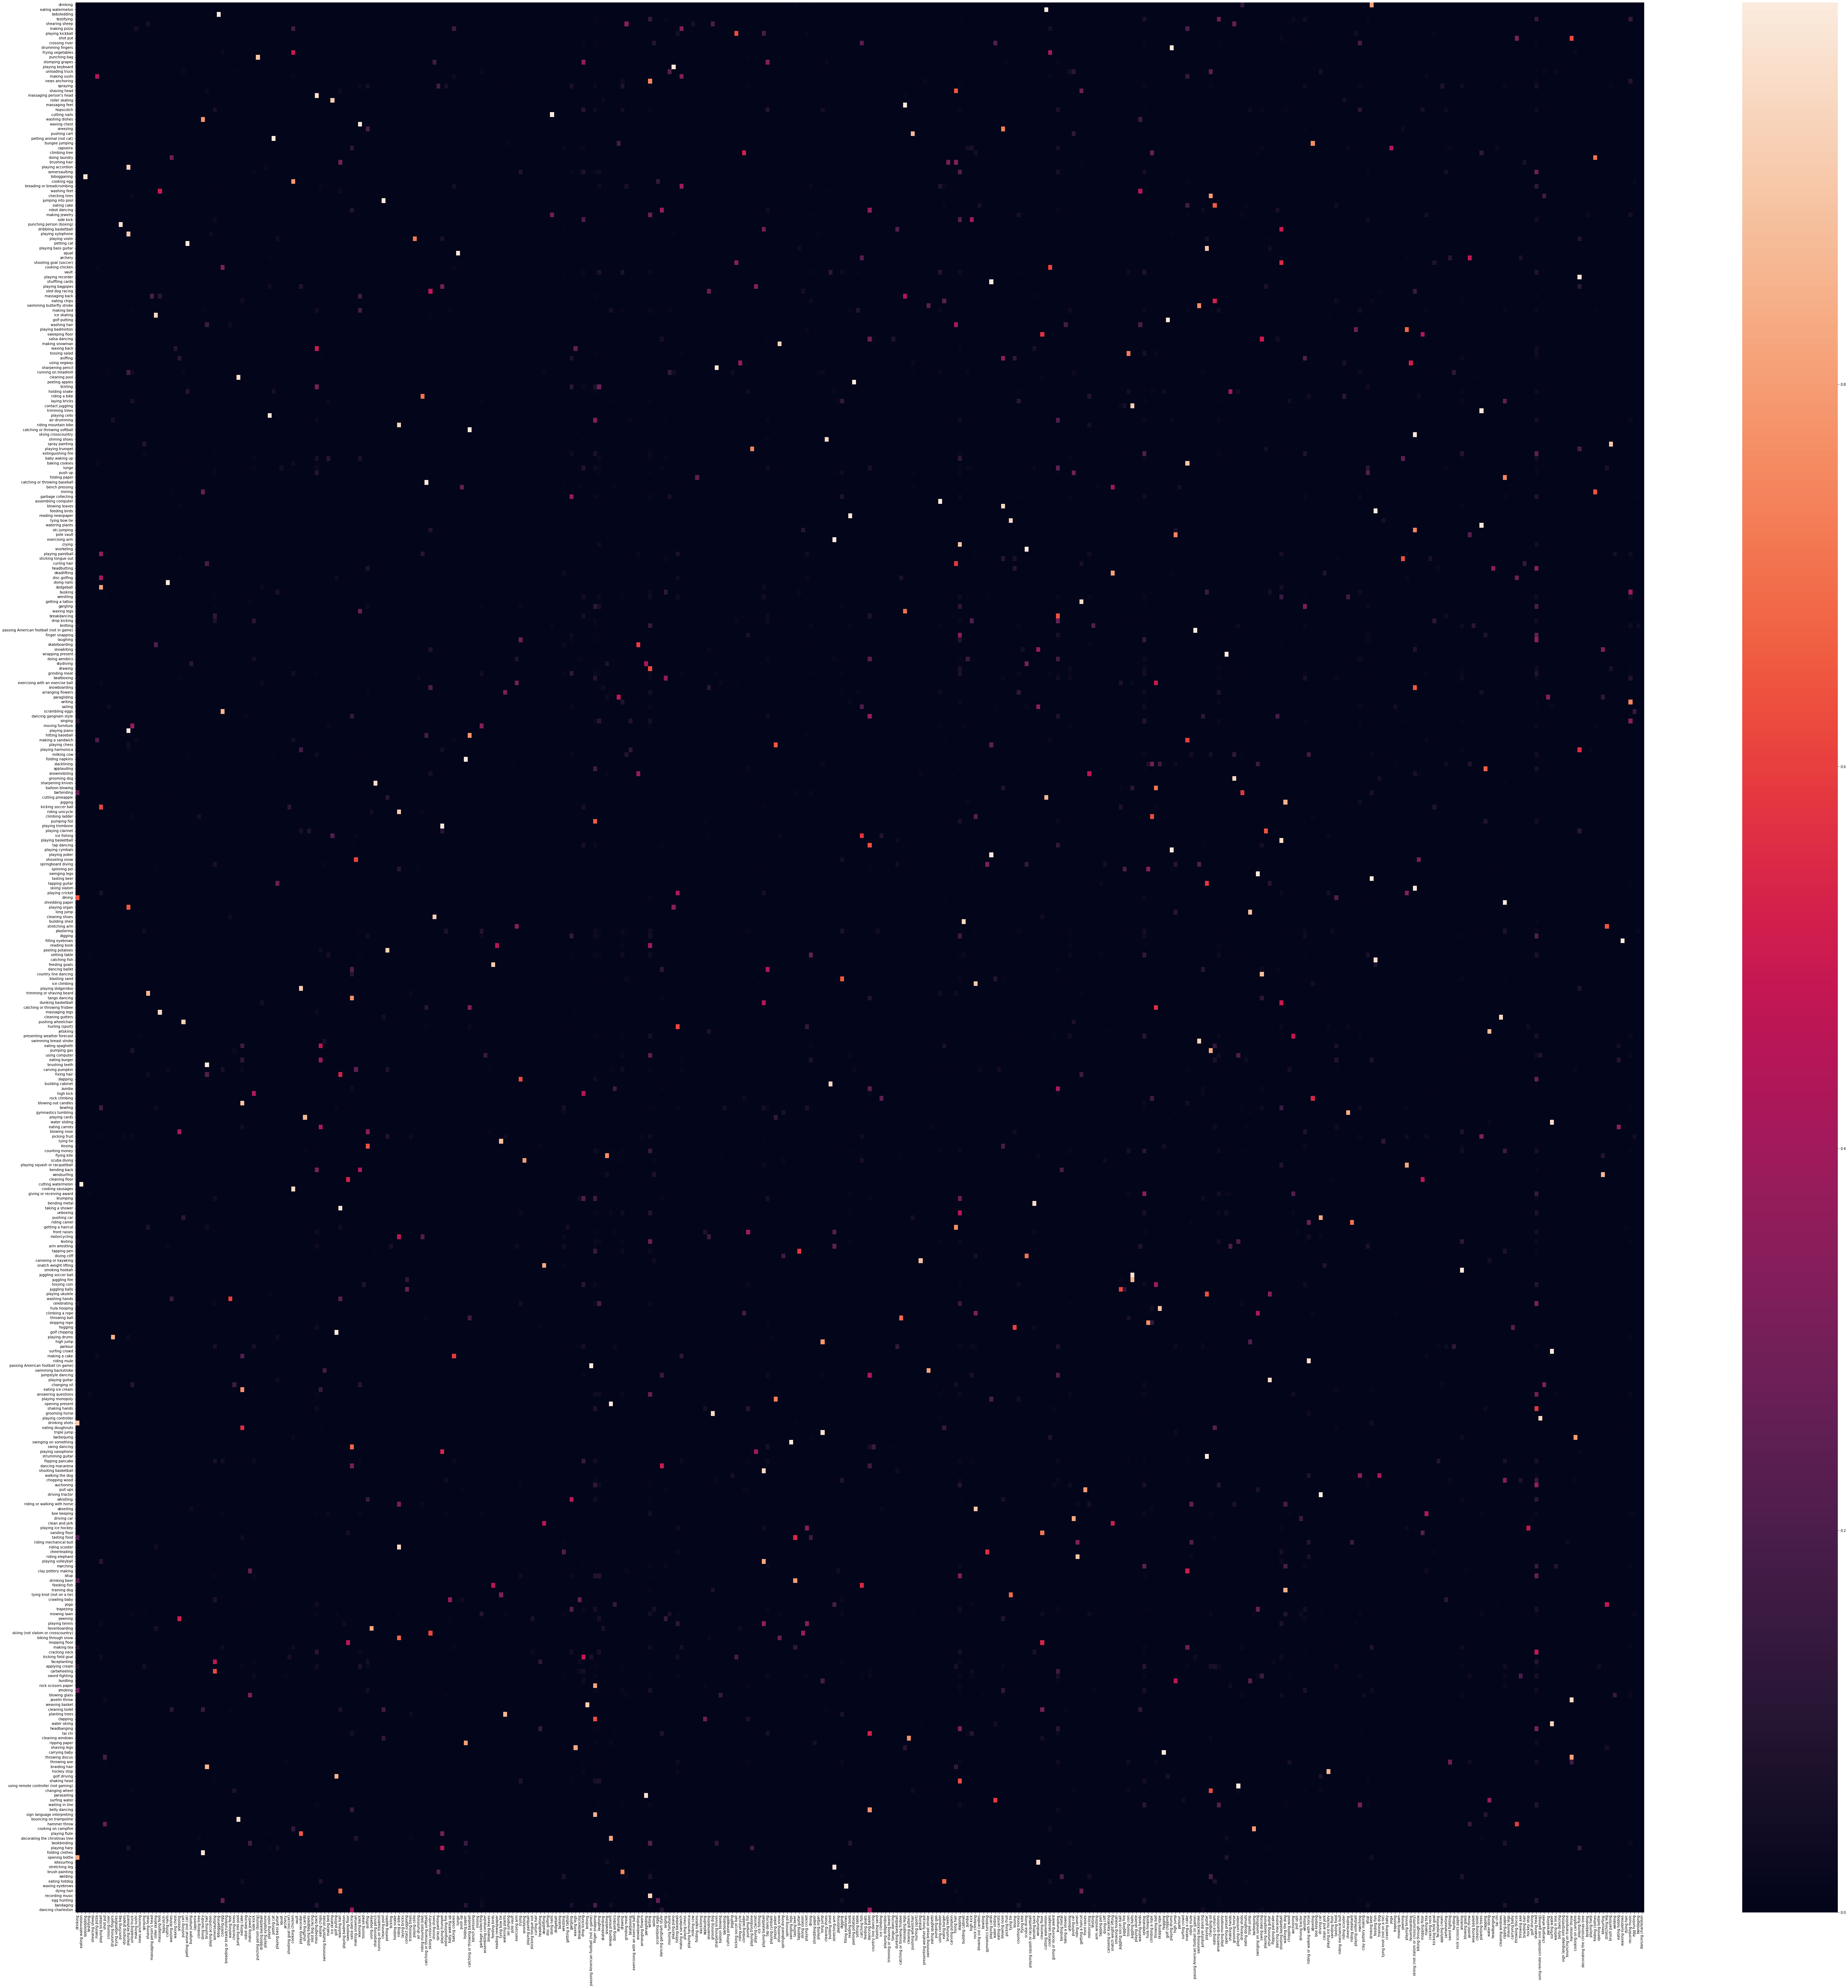

In [ ]:
plt.figure(figsize=(100, 100))
sns.heatmap(df)
plt.show()

In [4]:
with Path('data/proc_label_clustered.json').open() as f:
    babel_label_clustered = json.load(f)
label_dist = {k: freq for k, freq in Counter(proc_labels).most_common() if k != 'transition' and freq >= 10}
babel_label_clustered

NameError: name 'proc_labels' is not defined

6466 1676 4790


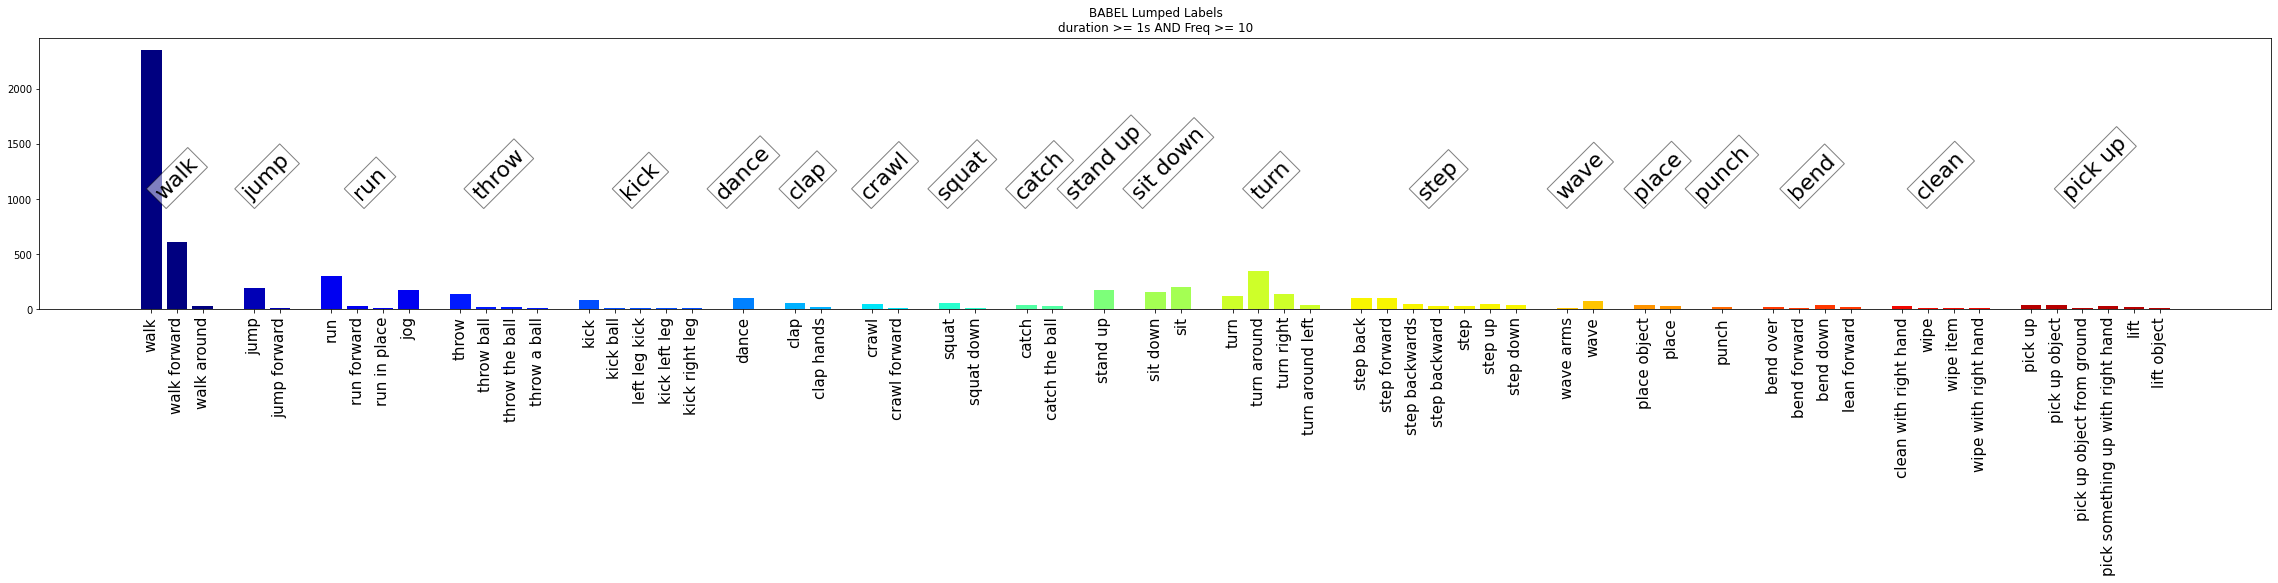

In [ ]:
num_parents = sum(len(child_labels) for child_labels in babel_label_clustered.values())
unks = ['walk', 'catch', 'stand up', 'sit down', 'turn', 'step', 'wave', 'place']
all_child_labels = []
all_child_freqs = []
freq_known, freq_unk = 0, 0
pointer = 0
xticks = []
jet = mpl.cm.get_cmap('jet')
plt.figure(figsize=(40, 5))
plt.title('BABEL Lumped Labels\nduration >= 1s AND Freq >= 10')
for i, (parent_label, child_labels) in enumerate(babel_label_clustered.items()):
    # if parent_label == 'walk': continue
    all_child_labels += child_labels
    curr_child_freqs = [label_dist.get(child_label, 0) for child_label in child_labels]
    all_child_freqs.append(curr_child_freqs)
    if parent_label in unks:
        freq_unk += sum(curr_child_freqs)
    else:
        freq_known += sum(curr_child_freqs)

    curr_xticks = np.arange(len(child_labels)) + pointer
    xticks += curr_xticks.tolist()
    plt.bar(curr_xticks, curr_child_freqs, color=jet(i/len(babel_label_clustered)))
    t = plt.text(curr_xticks.mean(), 1000, parent_label, horizontalalignment='center', fontsize=22, rotation=45)
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='black'))
    pointer += len(child_labels) + 1
print(sum(map(sum, all_child_freqs)), freq_known, freq_unk)
plt.gca().set_xticks(xticks, all_child_labels, rotation=90, fontsize=15)
plt.show()

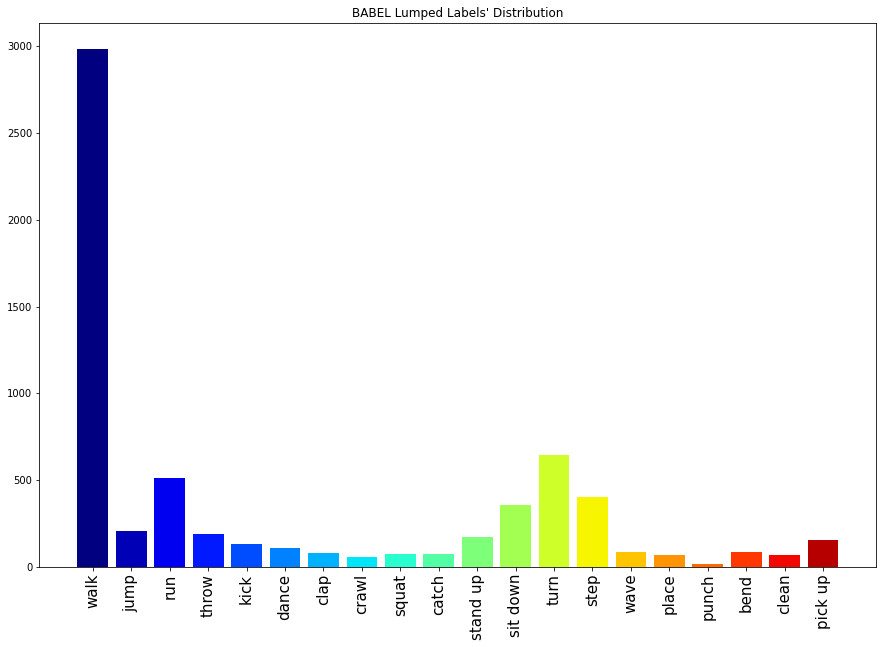

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('BABEL Lumped Labels\' Distribution')
for i, (parent_label, child_labels) in enumerate(babel_label_clustered.items()):
    curr_child_freqs = [label_dist[child_label] for child_label in child_labels]
    plt.bar([i], [sum(curr_child_freqs)], color=jet(i/len(babel_label_clustered)))
plt.gca().set_xticks(np.arange(len(babel_label_clustered)), babel_label_clustered.keys(), rotation=90, fontsize=15)
plt.show()